#Importing Packages and dataset

In [0]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import backend as K
import sklearn
from sklearn.model_selection import train_test_split

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Reshaping the data as per the model requirement

In [0]:
x_train = x_train.reshape(-1, 28,28, 1)/255
x_test = x_test.reshape(-1, 28,28, 1)/255

Splitting the data for validation

In [0]:
X,X_val,Y,Y_val = train_test_split(x_train,x_train,test_size=0.2)

#Autoencoder Model

In [0]:
input_img = Input(shape = (28, 28, 1))

In [0]:
def autoencoder(input_img):
    #encoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(8, (1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(2, (1, 1), activation='relu', padding='same')(x)
    x = Conv2D(1, (1, 1), activation='relu', padding='same')(x)
    #decoder
    x = Conv2D(2, (1, 1), activation='relu', padding='same')(x)
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(1, (3, 3), activation='tanh', padding='same')(x)
    return x

In [0]:
autoencoder_train = Model(input_img, autoencoder(input_img))
autoencoder_train.compile(loss='mean_squared_error', optimizer = Adam())

In [39]:
autoencoder_train.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 28, 28, 256)       2560      
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 28, 28, 128)       295040    
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 28, 28, 64)        73792     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 14, 14, 16)        4624

In [0]:
model_saver = tf.keras.callbacks.ModelCheckpoint("model_weights.h5", 
                                                 monitor='val_loss', verbose=1, 
                                                 save_best_only=True, 
                                                 save_weights_only=False, 
                                                 mode='auto')

In [57]:
history = autoencoder_train.fit(X,Y,epochs = 20,validation_data = (X_val,Y_val),callbacks = [model_saver])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
47968/48000 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 00001: val_loss improved from 0.00181 to 0.00179, saving model to model_weights.h5
48000/48000 [==============================] - 38s 785us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 2/20
47968/48000 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 00002: val_loss did not improve from 0.00179
48000/48000 [==============================] - 38s 785us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 3/20
47904/48000 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00003: val_loss did not improve from 0.00179
48000/48000 [==============================] - 38s 790us/sample - loss: 0.0016 - val_loss: 0.0019
Epoch 4/20
47968/48000 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00004: val_loss improved from 0.00179 to 0.00176, saving model to model_weights.h5
48000/48000 [==============================] - 38s 7

#Encoding-Decoding test images

Making seperate encoder and decoder models

In [0]:
encoder = Model(input_img,autoencoder_train.layers[11].output)

In [43]:
encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 28, 28, 256)       2560      
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 28, 28, 128)       295040    
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 28, 28, 64)        73792     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 14, 14, 16)        4624

In [0]:
idx = 12  # index of desired layer
input_shape = autoencoder_train.layers[idx].get_input_shape_at(0)[1:] # get the input shape of desired layer
layer_input = Input(shape=input_shape) # a new input tensor to be able to feed the desired layer

# create the new nodes for each layer in the path
x = layer_input
for layer in autoencoder_train.layers[idx:]:
    x = layer(x)

# create the model
decoder = Model(layer_input, x)

In [45]:
decoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 7, 7, 1)]         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 7, 7, 2)           4         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 7, 7, 4)           76        
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 7, 7, 8)           296       
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 14, 14, 32)        4640

In [0]:
code = encoder.predict(x_test)

28*28 image is coded to a 7*7  dimension space 

In [47]:
code.shape

(10000, 7, 7, 1)

In [0]:
extract = decoder.predict(code)

In [49]:
extract.shape

(10000, 28, 28, 1)

#Plotting original and extracted images

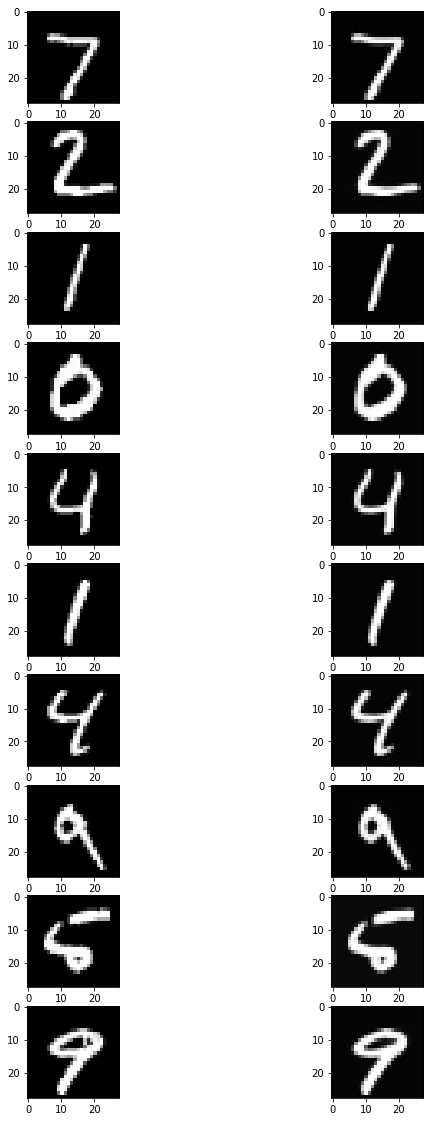

In [50]:
w=10
h=10
fig=plt.figure(figsize=(10, 20))
columns = 2
rows = 10
j = 0
k = 0
for i in range(1, columns*rows +1):
    if i%2 == 0:
        img = extract[j,...,0]
        j+=1
    else:
        img = x_test[k,...,0]
        k+=1
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap = 'gray')
plt.show()